In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import os
import sys
from glob import glob
from multiprocessing import Pool
import tempfile
import shutil
import imageio
from PIL import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from project.utils.geo_plots import savefig, plot_map
from project.utils.anim import animate

mpl.rcParams['font.family'] = 'monospace'
plt.rcParams['figure.dpi'] = 120

import dask
dask.config.set(scheduler='synchronous')

In [2]:
from project.utils.geo_plots import plot_map, savefig
from project.utils.geo import msc_align, msc2date, stacktime

In [3]:
cube = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
pred = xr.open_zarr('/Net/Groups/BGI/people/bkraft/drought_ml/experiments/default/exp_00_2023-04-05_09-54-05/cv/predictions.zarr/')

In [4]:
modis = xr.open_mfdataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d25_8daily/MODIS/MOD13C1.006/Data/NDVI/NDVI.1440.720.*.nc')

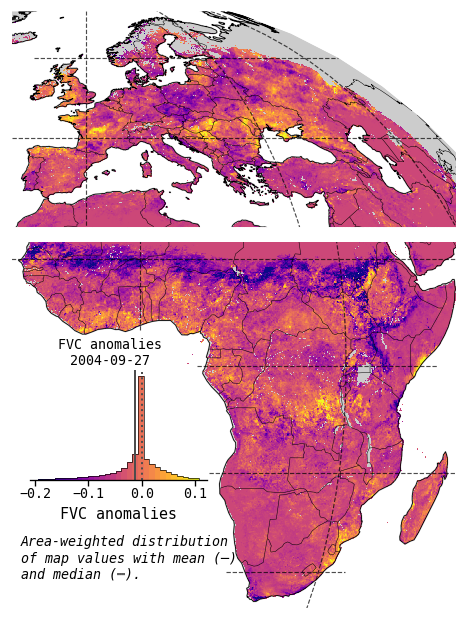

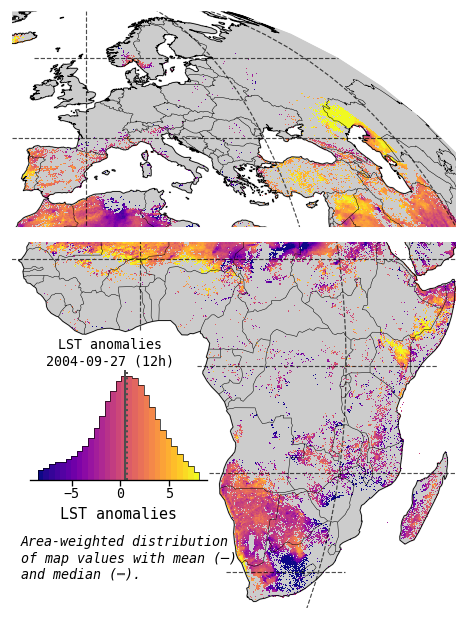

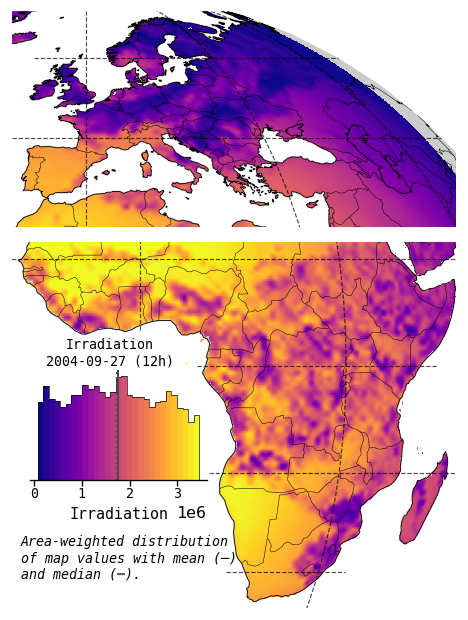

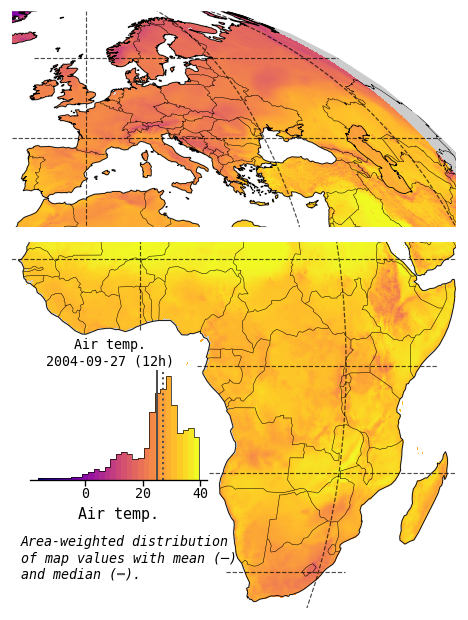

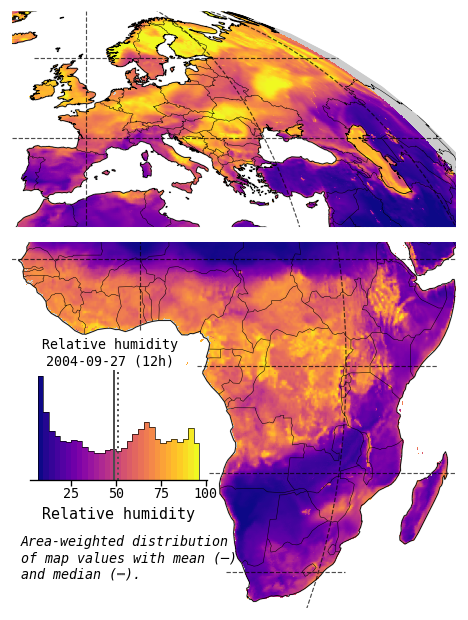

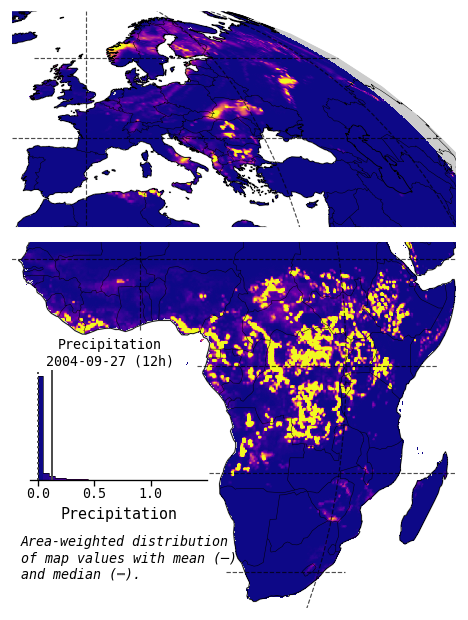

In [6]:
for key, name in {
    'fvc_ano': 'FVC anomalies',
    'lst_ano': 'LST anomalies',
    'ssrd': 'Irradiation',
    't2m': 'Air temp.',
    'rh_cf': 'Relative humidity',
    'tp': 'Precipitation'}.items():

    cube_sel = cube[key]

    if 'hour' in cube_sel.dims:
        cube_sel = cube_sel.isel(hour=12)
        hour = ' (12h)'
    else:
        hour = ''

    cube_sel = cube_sel.isel(time=(1000))

    date = cube_sel.time.dt.strftime('%Y-%m-%d').item()
    date += hour

    fig, _ = plot_map(
        cube_sel.load(),
        label=name,
        cmap='plasma',
        title=f'{name}\n{date}',
        robust=True,
        do_center=False
    );

    savefig(fig, path=f'../readme_imgs/{key}.png', dpi=150, transparent=True)

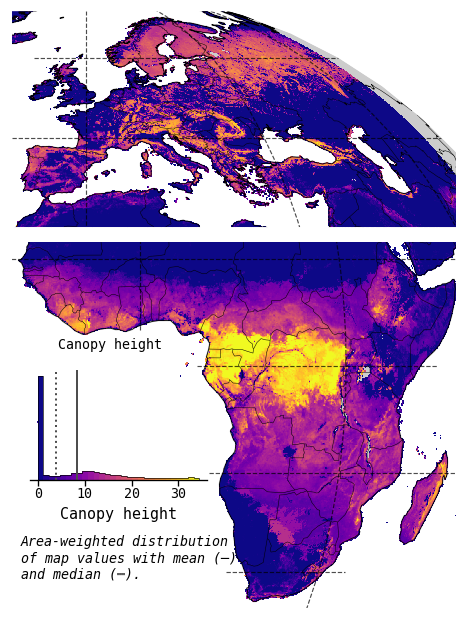

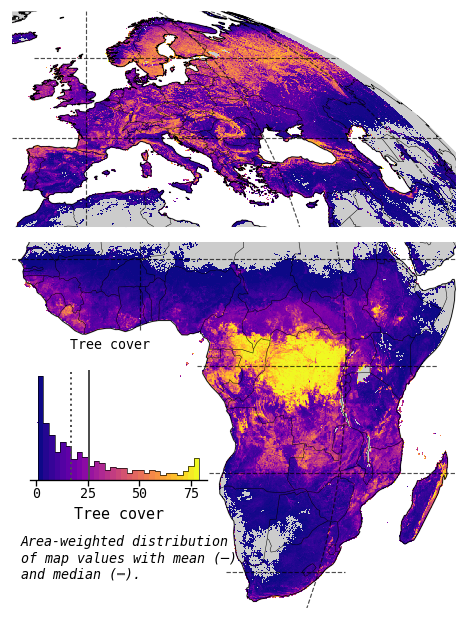

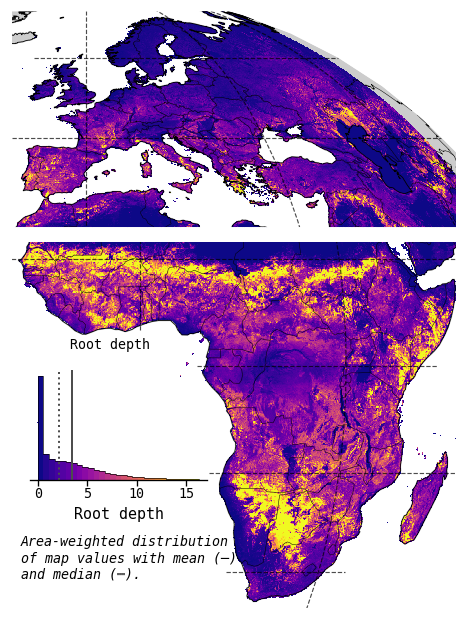

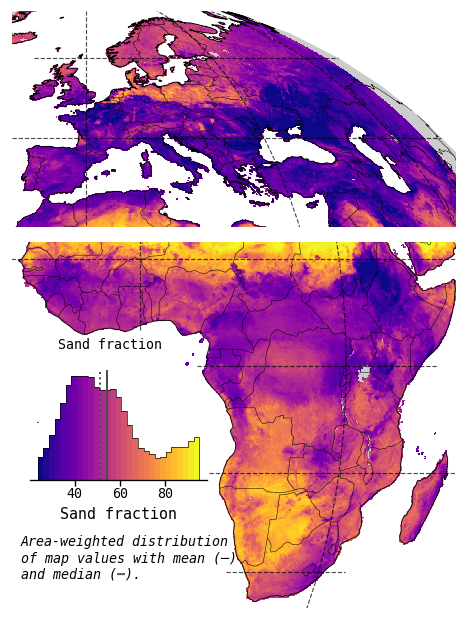

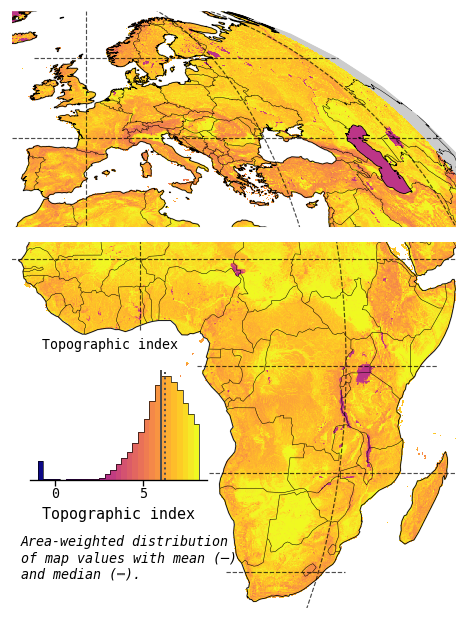

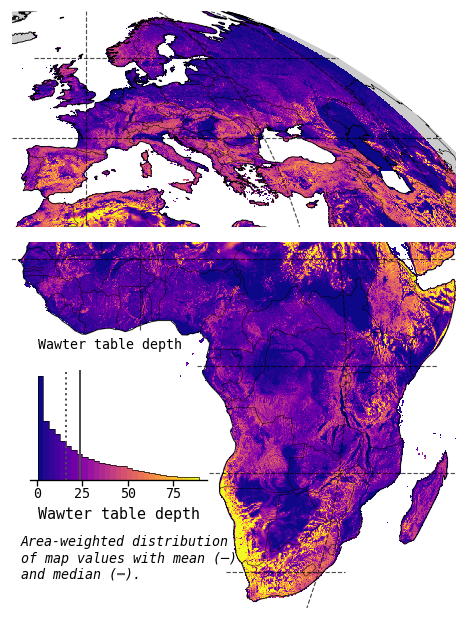

In [7]:
for key, name in {
        'canopyheight': 'Canopy height',
        'percent_tree_cover': 'Tree cover',
        'rootdepth': 'Root depth',
        'sandfrac': 'Sand fraction',
        'topidx': 'Topographic index',
        'wtd': 'Wawter table depth'}.items():

    fig, _ = plot_map(
        cube[key].load(),
        label=name,
        cmap='plasma',
        title=name,
        robust=True,
        do_center=False
    );

    savefig(fig, path=f'../readme_imgs/{key}.png', dpi=150, transparent=True)

In [11]:
modis

<xarray.Dataset>
Dimensions:    (time: 20, longitude: 7200, latitude: 3600)
Coordinates:
  * time       (time) datetime64[ns] 2000-02-22T00:00:00.000040 ... 2000-12-2...
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * latitude   (latitude) float64 89.98 89.93 89.88 ... -89.88 -89.92 -89.97
Data variables:
    LAI        (time, latitude, longitude) float32 ...
Attributes:
    title:        LAI gimms update
    version:      (LAI3gV1
    reference:    Chen, Chi, et al. "China and India lead in greening of the ...
    history:      created: Mon Aug 19 10:16:16 2019
    provided_by:  Chi Chen, Taejin Park, Baodong Xu & Ranga B. Myneni (Depart...
    created_by:   uweber@bgc-jena.mpg.de

In [24]:
modis_ss = modis.sel(latitude=slice(-29.0, -30.0), longitude=slice(20, 21), time=slice('2010', '2015')).mean(['latitude', 'longitude']).load()
cube_ss = cube.sel(lat=slice(-29.0, -30.0), lon=slice(20, 21), time=slice('2010', '2015')).mean(['lat', 'lon']).load()

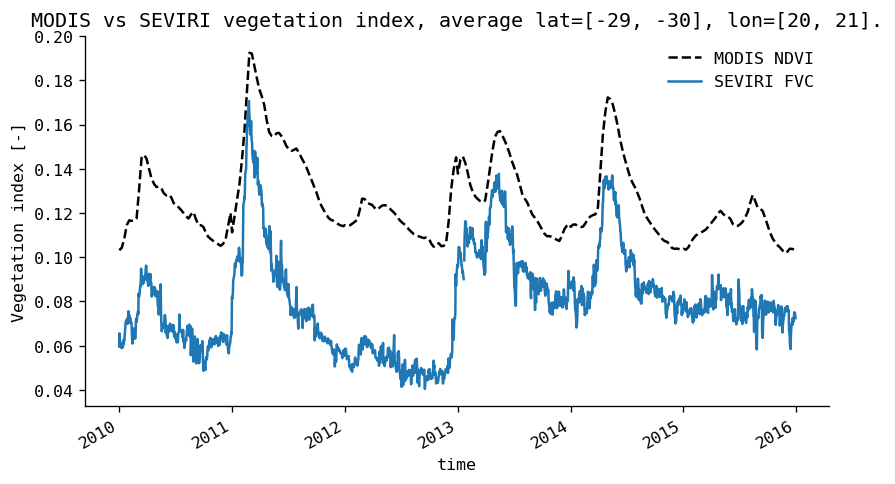

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))

modis_ss.NDVI.plot(label='MODIS NDVI', ax=ax, color='k', ls='--')
cube_ss.fvc.plot(label='SEVIRI FVC', ax=ax, color='tab:blue')
ax.set_title('MODIS vs SEVIRI vegetation index, average lat=[-29, -30], lon=[20, 21].')
ax.set_ylabel('Vegetation index [-]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)

#savefig(fig, path='../visualization/plots/modis_vs_seviri.png')

In [132]:
def plot_ts_setup(save_path, rel_pos, num_steps, obs, pred, dpi=150, box_width=0.3, min_pos=0.1):

    mx = 1.0 - box_width
    pos = ((rel_pos + 1) / num_steps) * (1.0 - min_pos) + min_pos
    box_start = max(pos - box_width, 0)
    box_width_ = min(pos, box_width)
    time_limit = int(len(preds.time) * pos)

    fig, axes = plt.subplots(6, 1, figsize=(15, 4), sharex=True)

    ax = axes[0]
    cubes.fvc.plot(ax=ax, color='k')

    ax = axes[1]
    obs.fvc_ano.plot(ax=ax, color='k')
    pred.fvc_ano_hat.isel(time=slice(0, time_limit)).plot(ax=ax, color='tab:orange', lw=1.2)
    ax.axhline(0, color='k', ls='--', lw=1., zorder=-1)

    for i, var in enumerate(['tp', 't2m', 'rh_cf', 'ssrd']):
        ax = axes[2 + i]
        im = obs[var].T.plot(ax=ax, add_colorbar=False, robust=True, cmap='inferno')

    labels = ['FVC', 'FVC anomalies', 'TP', 'T2M', 'RH', 'SSRD']
    for i, ax in enumerate(axes):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('')
        ax.set_title('')
        if i < 2:
            ax.set_ylabel('')

        ax.text(0.01, 0.5, labels[i], ha='left', va='center', transform=ax.transAxes,
                bbox=dict(boxstyle="square",
                       ec='none',
                       fc='w',
                ))


    rect0 = plt.Rectangle((pos - 0.002, 0), width=0.004, height=1,
                         transform=axes[1].transAxes, clip_on=False,
                         edgecolor='r', facecolor='none', linewidth=1, zorder=100)
    rect1 = plt.Rectangle((box_start, 0), width=box_width_, height=4 + 3 * fig.subplotpars.wspace,
                         transform=axes[-1].transAxes, clip_on=False,
                         edgecolor='r', facecolor='none', linewidth=4)
    rect2 = plt.Rectangle((box_start, 0), width=box_width_, height=4 + 3 * fig.subplotpars.wspace,
                         transform=axes[-1].transAxes, clip_on=False,
                         edgecolor='w', facecolor='none', linewidth=1)
    axes[1].add_patch(rect0)
    axes[-1].add_patch(rect1)
    axes[-1].add_patch(rect2)

    fig.savefig(save_path, dpi=dpi, bbox_inches='tight', transparent=True)
    plt.close(fig)
    del fig, axes

def animate_ts(save_dir, title, num_steps, dpi=150, cmap='BrBG', fps=15, ncpus=1):

    tmpdir = tempfile.mkdtemp(dir=os.path.dirname(save_dir))

    try:
        par_kwargs = [{
            'save_dir': os.path.join(tmpdir, f'frame_{t:04d}.png'),
            'rel_pos': t,
            'num_steps': num_steps,
            'obs': cubes,
            'pred': preds,
        } for t in range(num_steps)]

        par_args = [list(el.values()) for el in par_kwargs]

        with Pool(processes=min(len(par_args), ncpus)) as pool:
            pool.starmap(plot_ts_setup, par_args)

        fp_in = os.path.join(tmpdir, 'frame*.png')
        paths = sorted(glob(fp_in))

        #command = f'convert -delay {100 / fps} -loop 0 {fp_in} {save_path}'
        command = f'ffmpeg -y -threads 16 -framerate {fps} -pattern_type glob -i \'{fp_in}\' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p {save_dir}/{title.replace(" ", "_").lower()}.webm'
        print(command)
        os.system(command)
        print('Done.')

    finally:
        shutil.rmtree(tmpdir, ignore_errors=True)

animate_ts(save_dir='../visualization/anim/', title='pred_scheme', num_steps=1000, ncpus=20, fps=150)

ffmpeg -y -threads 16 -framerate 150 -pattern_type glob -i '../visualization/anim/tmp1wykbby6/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ../visualization/anim//pred_scheme.webm


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Done.


frame= 1000 fps=3.5 q=0.0 Lsize=    2430kB time=00:00:06.66 bitrate=2988.5kbits/s speed=0.0233x    
video:1696kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 43.243530%


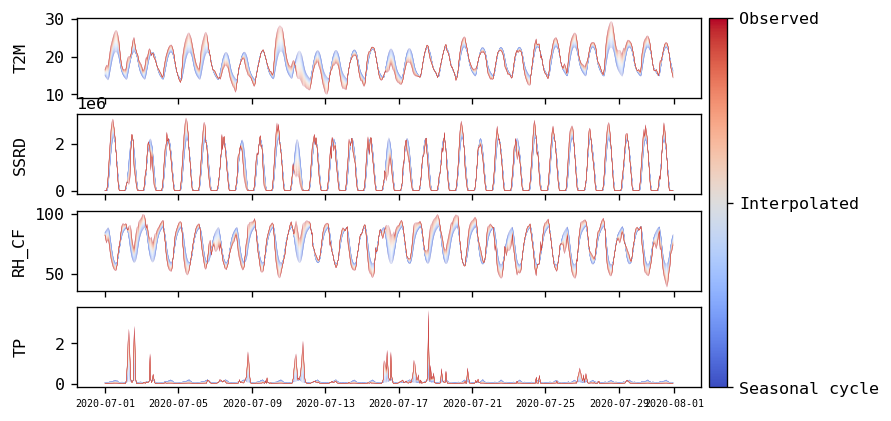

In [153]:
#y = slice('2019', '2020')
y = '2020-07'

fig, axes = plt.subplots(4, 1, figsize=(8, 4), sharex=True, squeeze=False)

cmap = mpl.cm.get_cmap('coolwarm')

for var_i, var in enumerate(['t2m', 'ssrd', 'rh_cf', 'tp']):
    ax = axes[var_i, 0]
    y0 = stacktime(msc_align(cube[var + '_msc'], cube)).sel(lat=50, lon=2, time=y).load()
    y1 = stacktime(cube[var].sel(lat=50, lon=20, time=y)).load()
    for c_i in np.linspace(0, 1, 50):
        col = cmap(c_i)
        y_ = y0 * (1 - c_i) + y1 * c_i
        im = y_.plot(ax=ax, color=col, lw=0.1, alpha=0.5)

    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel(var.upper())
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center', size=6)

fig.align_ylabels(axes)

norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('coolwarm'))
cmap.set_array([])
cbar = fig.colorbar(cmap, ax=axes, ticks=[0, 0.5, 1], pad=0.01)
cbar.ax.set_yticklabels(['Seasonal cycle', 'Interpolated', 'Observed'])


fig.savefig('../visualization/plots/ig_meteo.png', dpi=300, transparent=True)

In [6]:
def plot_t(ds_t, vmin, vmax, title, save_dir=None, dpi=200, cmap='BrBG', rotate=0, globe=True, t=False, is_hourly=True, **kwargs):

    extends = []

    if isinstance(vmin, str):
        if isinstance(vmax, str):
            extends.append('both')
        else:
            extends.append('min')
    else:
        if isinstance(vmax, str):
            extends.append('max')
        else:
            extends.append('neither')


    if is_hourly:
        time = ds_t.time.dt.strftime("%Y-%m-%d-%H").item()
    else:
        time = ds_t.time.dt.strftime("%Y-%m-%d").item()        

    fig, ax = plot_map(
        ds_t.load(),
        label=title,
        title=f'{time}',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

        #cbar.ax.xaxis.set_tick_params(color='w')
        #cbar.outline.set_edgecolor('w')
        #plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')

        #ax.set_title('')
        #ax.text(0.3, 0.3, f'{title} – {time}', transform=ax.transAxes, color='w')

    # fig.tight_layout()

    path = os.path.join(save_dir, f'frame_{time}.png')

    fig.savefig(path, dpi=dpi, bbox_inches='tight', transparent=True)
    plt.close(fig)
    del ds_t, ax, title

def animate(
        ds, vmin, vmax, title, save_path, timerange=-1, levels=None,
        globe=True, rotate_speed=0, dpi=150, cmap='BrBG', fps=15, ncpus=1, use_pil=False,
        png_out=False):

    tmpdir = tempfile.mkdtemp(dir=os.path.dirname(save_path))

    if isinstance(ds, xr.Dataset):
        raise TypeError('must pass an xr.DataArray, not an xr.Dataset.')
    elif isinstance(ds, xr.DataArray):
        if not isinstance(vmin, (int, float, str)):
            raise TypeError('`vmin` must be numeric or a string.')
        if not isinstance(vmax, (int, float, str)):
            raise TypeError('`vmax` must be numeric or a string.')
        if not isinstance(title, str):
            raise TypeError('`title` must be a string.')
        if not isinstance(cmap, str):
            raise TypeError('`cmap` must be a string.')

        ntime = len(ds.time)

    else:
        if not isinstance(vmin, list):
            raise TypeError('`vmin` must be a list as multiple datasets were passed.')
        if not isinstance(vmax, list):
            raise TypeError('`vmax` must be a list as multiple datasets were passed.')
        if not isinstance(title, list):
            raise TypeError('`title` must be a list as multiple datasets were passed.')
        if not isinstance(cmap, list):
            raise TypeError('`cmap` must be a list as multiple datasets were passed.')

        ntime = len(ds[0].time)

    if timerange == -1:
        timerange = range(ntime)
    elif isinstance(timerange, int):
        timerange = range(timerange)

    if isinstance(ds, list):
        timedim = ds[0]['time']
    else:
        timedim = ds['time']

    is_hourly = xr.infer_freq(timedim) == 'H'

    try:

        par_kwargs = [{
            'ds_t': ds.isel(time=t) if isinstance(ds, xr.DataArray) else [ds[i].isel(time=t) for i in range(len(ds))],
            'vmin': vmin,
            'vmax': vmax,
            'title': title,
            'save_dir': tmpdir,
            'dpi': dpi,
            'cmap': cmap,
            'rotate': t * rotate_speed,
            'globe': globe,
            't': t,
            'is_hourly': is_hourly
        } for t in timerange]

        par_args = [list(el.values()) for el in par_kwargs]

        # parcall(plot_t, ds_args, dry_run=False, num_cpus=ncpus, vmin=vmin, vmax=vmax, levels=levels,
        #     globe=globe, save_dir=tmpdir, title=title, cmap=cmap, dpi=dpi);

        with Pool(processes=min(len(par_args), ncpus)) as pool:
            pool.starmap(plot_t, par_args)

        fp_in = os.path.join(tmpdir, 'frame*.png')
        paths = sorted(glob(fp_in))

        if not png_out:
            #command = f'convert -delay {100 / fps} -loop 0 {fp_in} {save_path}'
            command = f'ffmpeg -y -threads 16 -framerate {fps} -pattern_type glob -i \'{fp_in}\' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p {save_path}/{title.replace(" ", "_").lower()}.webm'
            print(command)
            os.system(command)
            print('Done.')

        else:
            if os.path.isdir(save_path):
                shutil.rmtree(save_path)
            os.rename(tmpdir, save_path)

    finally:
        shutil.rmtree(tmpdir, ignore_errors=True)

        


In [7]:
animate(cube.fvc_ano.sel(time='2015').load(), vmin=-0.1, vmax=0.1, title='FVC anomalies', cmap='BrBG', save_path='../visualization/anim/', timerange=-1, ncpus=40, png_out=False, dpi=300)

ffmpeg -y -threads 16 -framerate 15 -pattern_type glob -i '../visualization/anim/tmpe_5lvnlk/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ../visualization/anim//fvc_anomalies.webm


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Done.


In [7]:
animate(cube.fvc.sel(time='2015').load(), vmin=0, vmax=1, title='FVC', cmap='viridis', save_path='../visualization/anim/', timerange=-1, ncpus=40, png_out=False)

ffmpeg -y -threads 16 -framerate 15 -pattern_type glob -i '../visualization/anim/tmp8pkp9nab/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ../visualization/anim//fvc.webm


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Done.


In [18]:
ds_miss = ds.fvc.sel(time=slice('2003', '2006')).isnull().all(('lat', 'lon')).compute()

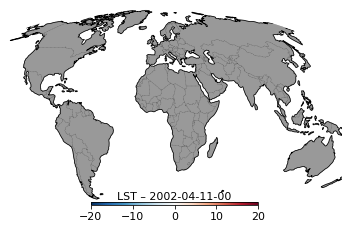

In [8]:
plot_t(ds.lst.isel(time=100, hour=7), vmin=-20, vmax=20, title='LST', cmap='RdBu_r', globe=True)

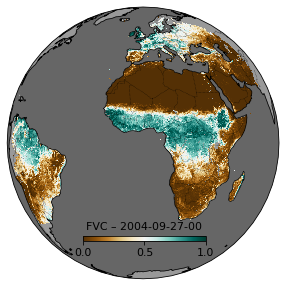

In [11]:
plot_t(ds.fvc.isel(time=700), 0, 1, 'FVC', globe=True)

In [6]:
fa = cube.fvc_ano.sel(lat=40, lon=-5, time=slice('2004', '2021')).load()
tp = cube.tp.sel(lat=40, lon=-5, time=slice('2004', '2021')).load()
attr = xr.open_zarr('../experiments/default/exp_00_2023-04-05_09-54-05/xai/integrated_gradients.zarr/').sel(lat=40, lon=-5, time=slice('2004', '2021')).load()

In [7]:
attr = attr.broadcast_like(fa)

In [14]:

with plt.xkcd():
    from matplotlib import patheffects
    plt.rcParams['path.effects'] = [patheffects.withStroke(linewidth=0)]
    fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

    ax = axes[0]
    stacktime(tp).plot(ax=ax, color='#81D8D0')
    ax.set_ylabel('Precipitation')
    ax.set_xlabel('')

    ax = axes[1]
    fv_0 = fa.where(fa > 0)
    fv_1 = fa.where(fa < 0)
    ax.fill_between(fv_0.time, fv_0 * 0, fv_0, color='#98FF98')
    ax.fill_between(fv_0.time, fv_1, fv_1 * 0, color='#F67280')
    ax.set_ylabel('Vegetation anomalies')

    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.set_title('')


    ax.annotate('',
                xy=(0.5, 1.8), xycoords=ax.transAxes,
                xytext=(0.75, 1.8), textcoords=ax.transAxes,
                arrowprops=dict(
                    color='k',
                    arrowstyle='|-|',
                    mutation_scale=2
                ))

    ax.text(0.625, 1.82, 'lag k', transform=ax.transAxes, size=9, color='k', ha='center', va='bottom')

    ax.annotate('',
                xy=(0.75, 0.32), xycoords=ax.transAxes,
                xytext=(0.5, 1.25), textcoords=ax.transAxes,
                arrowprops=dict(
                    color='k',
                    arrowstyle='-|>',
                    connectionstyle='arc3,rad=0.3',
                ))
    ax.text(0.57, 0.8, 'How does covariate x at lag k contribute to y at time t?', transform=ax.transAxes, size=9, color='k')

    ax.axvline(x=17500, ymin=0.24, ymax=0.42, c='k', linewidth=1.5, zorder=100, clip_on=False)
    ax.axvline(x=15722, ymin=1.24, ymax=1.65, c='k', linewidth=1.5, zorder=100, clip_on=False)

    fig.savefig('../visualization/plots/xai_concept.png', dpi=300, transparent=True, bbox_inches='tight')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

''

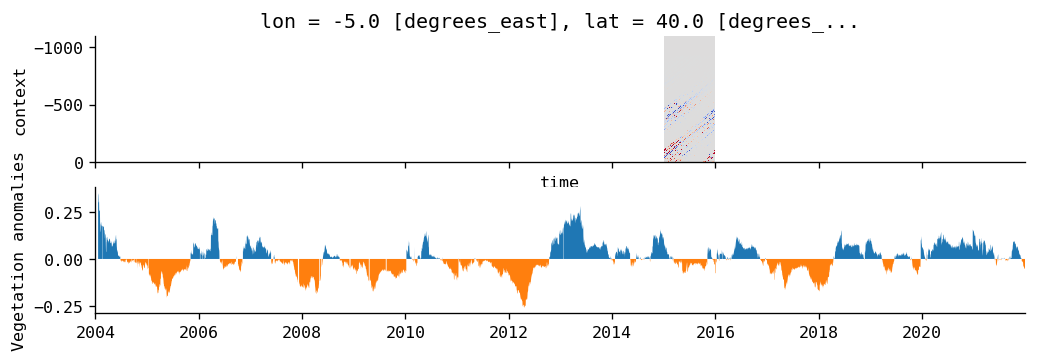

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

ax = axes[0]
attr.tp.T.plot(ax=ax, add_colorbar=False, vmin=-0.002, vmax=0.002, cmap='coolwarm')
ax.invert_yaxis()

ax = axes[1]
fv_0 = fa.where(fa > 0)
fv_1 = fa.where(fa < 0)
ax.fill_between(fv_0.time, fv_0 * 0, fv_0)
ax.fill_between(fv_0.time, fv_1, fv_1 * 0)
ax.set_ylabel('Vegetation anomalies')

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

;